[View in Colaboratory](https://colab.research.google.com/github/Claude47/speech_music_discrimination/blob/master/feature_extraction.ipynb)

Sound Class

In [6]:
!pip install dropbox

    100% |████████████████████████████████| 471kB 2.0MB/s 


In [0]:
import numpy as np
import scipy as sc
from scipy.signal import welch
from scipy.fftpack import fft
from scipy.fftpack import dct 
from scipy.fftpack import dst
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import wave
from os.path import *
import os
from functools import partial
import dropbox

from google.colab import files
import struct

In [0]:
def upload_local_file():
    '''used to upload local .wav files f'''
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

class sound:    
    raw_audio = 0
    def __init__(self, path, from_drive=True, dbx_access_token='jym07rxV7JAAAAAAAAAASYVjyBOd0G9JJKzC_5dgzrDHKeVsdZG1akcSvWnYBoKd'):
        '''sound object, initialise with path to .wav file'''
        self.from_drive = from_drive
        self.path = path
        self.dbx_access_token = dbx_access_token
        self.dbx = dropbox.Dropbox(self.dbx_access_token)
        self.file = self.read_wave_file()
        self.params, self.raw_audio = self.extract_raw_audio()
        if self.from_drive:
          self.frame_count = self.file.getnframes()
        else:
          self.frame_count = len(self.raw_audio)
    
    def read_wave_file(self):
      if self.from_drive:
        file = wave.open(self.path, 'rb')
      else:
        if not self.path.startswith('/'):
          path = '/' + self.path
        else:
          path = self.path
        _, file = self.dbx.files_download(path)
        file = file.content
      return file
      
    def parameters(self):
        '''returns parameters of .wav [nchannels, sampwidth, framerate, nframes, comptype, compname]'''
        return self.file.params

    def close(self):
        return self.file.close()
  
    def extract_raw_audio(self): 
        '''extract raw audio needed for dsp'''
        if self.from_drive:
          signal = self.file.readframes(-1)
          raw_audio = np.fromstring(signal,'int16')
        else:
          params, raw_audio = self.read_wav_string(self.file)
        return params, raw_audio
      
    def visualise_time(self):
        '''plot raw_audio'''
        plt.plot(self.raw_audio)
        plt.show()
    
    
    def read_wav_string(self, byte_string):
      wav_file = {'chunk_id': struct.unpack(">I", byte_string[:4]),
                  'chunk_size': struct.unpack("<I", byte_string[4:8]),
                  'format': struct.unpack(">I", byte_string[8:12]),
                  'subchunk1_id': struct.unpack(">I", byte_string[12:16]),
                  'subchunk1_size': struct.unpack(">I", byte_string[16:20]),
                  'audio_format': struct.unpack("<H", byte_string[20:22]),
                  'num_channels': struct.unpack("<H", byte_string[22:24]),
                  'sample_rate': struct.unpack("<I", byte_string[24:28]),
                  'byte_rate': struct.unpack("<I", byte_string[28:32]),
                  'block_align': struct.unpack("<H", byte_string[32:34]),
                  'bits_per_sample': struct.unpack("<H", byte_string[34:36]),
                  'subchunk2_id': struct.unpack(">I", byte_string[36:40]),
                  'subchunk2_size': struct.unpack("<I", byte_string[40:44])}
      wav_file = {k: wav_file[k][0] if isinstance(wav_file[k], tuple) else wav_file for k in wav_file.keys()}
      data = np.array([struct.unpack("<h", byte_string[44:][i:i+2]) for i in range(len(byte_string[44:]))[::2]])
      wav_file['sample_count'] = len(data)
      return wav_file, data
         

In [0]:
sound_dbx = sound('mssp4.wav', from_drive=False)

In [22]:
sound_dbx.params

{'audio_format': 1,
 'bits_per_sample': 16,
 'block_align': 2,
 'byte_rate': 44100,
 'chunk_id': 1380533830,
 'chunk_size': 220536,
 'format': 1463899717,
 'frame_count': 110250,
 'num_channels': 1,
 'sample_rate': 22050,
 'subchunk1_id': 1718449184,
 'subchunk1_size': 268435456,
 'subchunk2_id': 1684108385,
 'subchunk2_size': 220500}

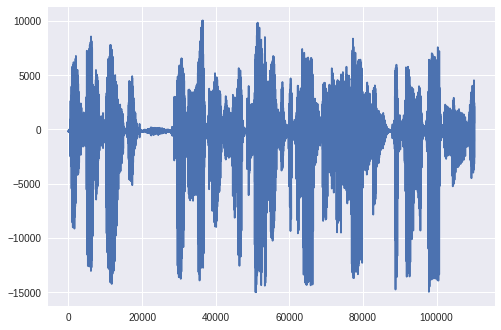

In [5]:
plt.plot(sound_dbx.raw_audio)

In [6]:
'''Test visualisation'''  
upload_local_file()
path = "mssp4.wav"
sound1 = sound(path) 
sound1.extract_raw_audio()

print(sound1.raw_audio)
sound1.visualise_time()
print(sound1.parameters())
         

FileNotFoundError: ignored

### Low energy frames feature extraction

This is a good measure of how much of a signal is quiet relative to the rest of a signal.



In [0]:
def extract_low_energy_frames(sound):
    '''step1: break raw into frames'''
    sound.extract_raw_audio()
    raw = sound.raw_audio
    
    fs = sound.parameters()[2] #framerate
    nframes = sound.parameters()[3] #number of frames
    threshold = 1000
     
    '''step2: use threshold to identify silence'''
    silent,loud = 0,0
    for i in range(0,nframes):  
        if(abs(raw[i])>threshold):
            loud=loud+1
        else:
            silent=silent+1
    
    '''step3: calculate % of low energy frames'''
    print(silent)
    print(loud)
    print(silent+loud," ",nframes)
    return (silent/nframes)*100
   

In [30]:
'''Test percentage of low energy frames feature extraction'''
upload_local_file()
path = "msms1.wav" #speech
path2 = "msmn1.wav" #music
sound1 = sound(path)
sound2 = sound(path2)
percent1 = extract_low_energy_frames(sound1)
percent2 = extract_low_energy_frames(sound2)
print(percent1)
print(percent2)

#results seem to match speech has high percentage silence, music has low, need 
#to tweaek threshold possibly

FileNotFoundError: ignored

# Facts about our experimental setup

## sounds used:
We made use of the souds provided at the following link

## Design Choices:
During feature generation we decided on a Maximum interval for measuring speech characterics:
This should be fixed at 20ms since human perception isn’t more precise than this. More so, speech signals remain constant for about 5-20 milliseconds. https://ieeexplore.ieee.org/document/1386250/

There is a 25% overlap between windows chosen for feature extraction over the whole interval of the sound.

# Feature Exploration

## Low-level Signals

### rms
https://dsp.stackexchange.com/questions/19337/what-is-the-rms-value-of-a-signal-and-how-to-use-it

RMS is the root-mean-square value of a signal. For a digitised signal, you can calculate it by squaring each value, finding the arithmetic mean of those squared values, and taking the square root of the result.

Loosely speaking, it represents the average "power" of a signal.  

#### definition 
$rms = \sqrt{1/N\sum_{i=1}^{N} |x[i]|^2}$
  
#### what are we trying to do?
Calculate the signal rms on intervals of 20ms.

### spectral centroid
The spectral centroid is a measure characterise a spectrum indicating where "center of mass" of the spectrum is located. Perceptually, it has a robust connection with the impression of "brightness" of a sound. (wikipedia)
This is done using the Fourier transform’s frequency and magnitude information. (https://ccrma.stanford.edu/~unjung/AIR/areaExam.pdf)

#### definition
$spectral centroid = \sum_{k=1}^{N} kF[k] / \sum_{k=1}^{N} F[k]$
where F[k] is is the amplitude corresponding to bin k in DFT spectrum

### zero crossing rate
The zero-crossing rate is the rate of sign-changes along a signal. This has been used in speech recognition research has identified it as a key feature for classifying percussive sounds. (https://en.wikipedia.org/wiki/Zero-crossing_rate)

#### definition 
https://www.asee.org/documents/zones/zone1/2008/student/ASEE12008_0044_paper.pdf

$zero crossing rate =  \sum_{m=\infty}^{\infty} |sgn[x(m)-sgn[x(m-1)]|w(n-m) $

### spectral roll-off frequency
This is a measure measure of the amount of the right-skewedness of the power spectrum. The spectral rolloff point is the fraction of bins in the power spectrum at which 85% of the power is at lower frequencies. http://jaudio.sourceforge.net/jaudio10/features/spectralrolloffpoint.html

https://dsp.stackexchange.com/questions/10159/spectral-shape-and-properties


### band energy ratio

### delta spectrum magnitude

### pitch

### pitch strength

## preprocessing
Our sound files are about 110250 samples in length as per papaer https://pdfs.semanticscholar.org/67c9/df42b82425afc4801b92b115c8921bf4cab7.pdf we split try to aim for a feature pack of length approx 30000 samples, with overlap of 25%.

## feature extraction rms value

In [0]:
def rms(sound, window_size, window_overlap):
    """function to calculate the rms values of subwindows of a signal"""
    raw_audio = sound.raw_audio
    rms_values = [rms_window(raw_audio[i:i+window_size]) for i in range(0,len(raw_audio),round((1-window_overlap)*window_size))]
    return rms_values
  
def rms_window(window):
    """function return the rms value of a window"""
    return np.sqrt(1/len(window)*np.sum(window*window))
  

Text(0,0.5,'rms value')

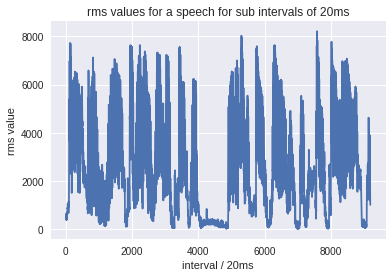

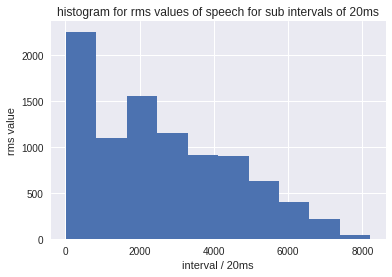

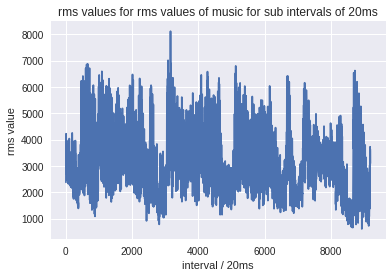

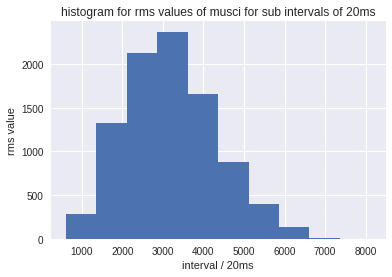

In [69]:
"""testing rms value"""
file_path_speech = "mssp1.wav"
file_path_music = "msmv3.wav"
speech = sound(file_path_speech, from_drive=False)
music = sound(file_path_music, from_drive=False)

#50 samples corresponds to 20ms at sample frequency of 22kHz
rms_values_speech = rms(speech,50,0.75)
rms_values_music = rms(music,50,0.75)
#print(len(sound1.raw_audio))

#histograms plotted with scipy.stats.gaussian_kde

plt.figure(0)
plt.plot(rms_values_speech)
plt.title("rms values for a speech for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")

plt.figure(1)
plt.hist(rms_values_speech)
plt.title("histogram for rms values of speech for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")

plt.figure(3)
plt.plot(rms_values_music)
plt.title("rms values for rms values of music for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")

plt.figure(4)
plt.hist(rms_values_music)
plt.title("histogram for rms values of musci for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")



## Thoughts on test:
Speech has a more left skewed histogram, whereas music with vocals has a more normally distributed histogram. music without vocals is less discernable from speech as it also skews left.

The shapes of the histogram suggest that it will be easier to discern music with vocals against speech with this feature as the music without vocals histograms are similiarly skew as the speech.

## feature extraction spectral centroid

In [0]:
def spectral_centroid(sound, bin_size):
    """compute spectral centroid of raw_data"""
    # calcultate sample length
    raw_audio = sound.raw_audio
    sample_rate = sound.params['sample_rate']
    n = len(raw_audio) #signal length
    
    # note: bin_size = sample_rate / fft_size 
    fft_window_size = int(sample_rate/bin_size)
    # print(signal_length," ",sample_rate," ", bin_size," ",fft_window_size)
      
    # calculate fft for various fft windows and centroid for each sub fft
    centroids = sub_sc(raw_audio[0:fft_window_size],n,sample_rate,bin_size)
    #centroids = [sub_sc(raw_audio[i:i+fft_window_size],n, sample_rate, bin_size) for i in range(0,len(raw_audio),fft_window_size)]            
    
    '''
    for i in range(len(centroids)):
        print(centroids[i]," ")
    '''
    print("average: ",np.average(centroids))
    return    

def sub_sc(raw_audio_subarray, n, sample_rate, bin_size):
    # calculate fft

    v_fft = fft(raw_audio_subarray)
   
    return stSpectralCentroidAndSpread(v_fft,sample_rate)

def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))
    
    eps = 0.00000001
    
    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = np.sqrt(np.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return C
    

In [0]:
def spectral_centroid2(sound, window_size):
    """compute spectral centroid of raw_data"""
    raw_audio = sound.raw_audio
    fft_window_size = int(sample_rate/bin_size)
    centroids = [sc_window(raw_audio[i:i+window_size],sample_rate) for i in range(0,len(raw_audio),window_size/4)]            
    return centroids
    
def sc_window(x,sample_rate):
    """computes spectral window for a frame x provided"""
    length = len(x)
    freq = (np.arange(1, length+1)) * (sample_rate/(2.0 * length))
    mag = np.abs(np.fft.fft(x))
    temp = mag.copy()
    temp = temp/temp.max()
    # compute the centroid per equation
    return np.sum(freq*mag)/np.sum(mag)

In [14]:
"""testing spectral centroid value"""
file_path2 = "mssp1.wav"
sound2 = sound(file_path2, from_drive=False)
sc = spectral_centroid(sound2,1)
sc2 = spectral_centroid2(sound2,2)
print(sc)
print(sc2)

average:  (11025.500000403848+0j)
length:  110250
None
60780825.0


## feature extraction zero crossing rate

In [0]:
def zero_crossing_rate(sound, window_size, window_overlap):
    """function to compute the zero crossing rate for subwindows of a sound"""
    raw_audio = sound.raw_audio
    zcr_values = [zcr_window(raw_audio[i:i+window_size]) for i in range(0,len(raw_audio),round((1-window_overlap)*window_size))]
    return zcr_values
  
def zcr_window(window):
    """calculates the zero crossing rate for a window"""
    length = len(window)
    window2 = window[1:length] #ommit first value of window, so window1 and windo1 to align as n - n-1
    window = window[0:length-1]
    return 0.5*np.sum(np.absolute(np.sign(window)-np.sign(window2))) #zcr
     
  

Text(0,0.5,'rms value')

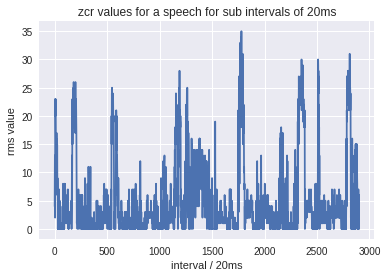

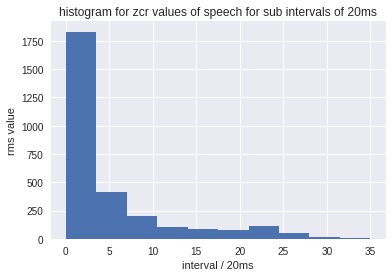

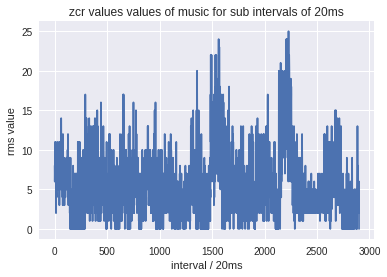

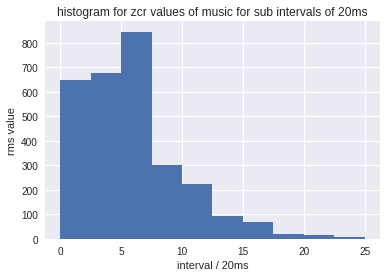

In [72]:
'''testing zero crossing rate'''
file_path_speech = "mssp1.wav"
file_path_music = "msmv3.wav"
speech = sound(file_path_speech, from_drive=False)
music = sound(file_path_music, from_drive=False)

#50 samples corresponds to 20ms at sample frequency of 22kHz
#window overlap of 0.25
zcr_values_speech = zero_crossing_rate(speech,50,0.25)
zcr_values_music = zero_crossing_rate(music,50,0.25)
#print(len(sound1.raw_audio))

#histograms plotted with scipy.stats.gaussian_kde

plt.figure(0)
plt.plot(zcr_values_speech)
plt.title("zcr values for a speech for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")

plt.figure(1)
plt.hist(zcr_values_speech)
plt.title("histogram for zcr values of speech for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")

plt.figure(3)
plt.plot(zcr_values_music)
plt.title("zcr values values of music for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")

plt.figure(4)
plt.hist(zcr_values_music)
plt.title("histogram for zcr values of music for sub intervals of 20ms")
plt.xlabel("interval / 20ms")
plt.ylabel("rms value")



## feature extraction spectral roll-off frequency

In [0]:
def spectral_rolloff_frequency(sound, window_size, window_overlap):
    raw_audio = np.asarray(sound.raw_audio)
    raw_audio.flatten()
    fs = sound.params.get("sample_rate")
    
    #shift window and take sub_spectrum
    spectogram = [sub_spectogram(raw_audio[i:i+window_size]) for i in range(0,len(raw_audio),round((1-window_overlap)*window_size))]    
    spec = np.mean([spectogram[i:i+window_size] for i in range(0,len(spectogram),round((1-window_overlap)*window_size))], axis=0)
    plt.plot(spec)
    return 
  
def sub_spectogram(window):
    #step1: detrend
    mean = np.mean(window)
    window = window-np.ones(len(window))*mean
    
    #step2: windowing 
    window = window*signal.hann(len(window))
    
    #step3: take fft
    return np.fft.fft(window)

In [0]:
ms_per_frame = 25 / 1000.
frame_size = ms_per_frame * fs
overlap = frame_size // 2
f, pxx = welch(speech_audio, fs=fs, window='hamming', nperseg=frame_size, noverlap=overlap)

In [4]:
"""testing spectral roll-off frequency"""

file_path_speech = "mssp1.wav"
file_path_music = "msmv3.wav"
speech = sound(file_path_speech, from_drive=False)
music = sound(file_path_music, from_drive=False)

#50 samples corresponds to 20ms at sample frequency of 22kHz
fs = speech.params.get('sample_rate')
n = fs*20
print(n)
#window overlap of 0.25
spectral_rolloff_frequency(speech,n,0.5)

print(len(f), " ", len(Pxx_den)) 

'''
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
'''

NameError: ignored

## Mel-frequency cepstrum (MFC)

**Cepstrum**: the Fourier inverse of the logarithm of the spectrum of a signal. It can be seen as information about the rate of change in different spectral bands.

**Power cepstrum**:

$P_c = |F^{-1}\{log(|F\{f(t)\}|^2)\}|^2$

**Mel scale**: a perceptual scale of pitches judged by listeners to be equal in distance from one another.

Conversion from *f* hertz to *m* mels:

$m = 2595 log_{10}(1 +\frac{f}{700})$

Conversion from *m* mels to *f* hertz:

$f = 700(10^{\frac{m}{2595}} - 1) = 700(e^{\frac{m}{1127}} - 1)$

MFC is a representation of the short-term power spectrum of a sound based on the mel scale. Mel-frequency cepstral coefficients (MFCCs) are coefficients that make up an MFC. They are derived from a cepstral representation of an audio clip. MFC differs from the cepstrum in that in the MFC, the frequency bands are equally spaced on the mel scale.

To calculate MFCCs:

1. Take fourier transform of signal

2. Convert transform to powers

3. Convert powers to mel scale

4. Take logs of mel powers

5. Take discrete cosine transform of mel log powers

6. The MFCCs are the amplitudes of the above quantities


52 features total:

1. 1-13: DC values of the MFCC coefficients

2. 14-26: 1-2Hz modulation energy of the MFCC coefficients

3. 27-39: 3-15Hz modulation energy of MFCC coefficients

4. 40-52: 20-150 modulation energy of MFCC coefficients

### Discrete Cosine Transform (Type II)

The DCT comes in 8 forms. The most common one is the Type II DCT, defined below:

$y[k] = 2 \Sigma^{N-1}_{n=0} x[n]cos(\frac{\pi (2n+1)k}{2N}) \textrm{  for 0 <= k < N} $

The DCT can be normalized by multiplying by a scale factor f:

f = sqrt(1/4N) if k = 0 or sqrt(1/2N) otherwise

In [0]:
file_name = 'mssp4.wav'
sanje_mssp4 = sound(file_name, from_drive=False)

In [0]:
sanje_mssp4_data = sanje_mssp4.raw_audio

In [0]:
x = np.abs(np.fft.fft(sanje_mssp4_data)) ** 2
x = np.log(x + 1e-15)

In [0]:
def frame_signal(signal, sampling_rate=44100, frame_size=25, overlap=0.5):
    """
    Args
        frame_size: (int) frame size in milliseconds
    """
    frame_size = frame_size / 1000. * sampling_rate
    step = int(round(frame_size * (1 - overlap)))
    signal = [signal[i: i + step] for i in range(0, len(signal), step)]    
    print "Frame size: %d\nOverlap: %.0f%%/%d frames\nNumber of frames: %d" \
          % (frame_size, 100 * overlap, step, len(signal))
    return signal
    

def mel(f):
    """Map f to mel scale"""
    return 1125 * np.log(1 + f / 700.)

def inverse_mel(m):
    """Map mel frequency to hertz"""
    return 700 * (np.exp(m / 1125.) - 1)
    
def get_mel_filterbank(lower_freq=300, fft_size=256, sampling_rate=44100, num_banks=26):
    mel_lower = mel(lower_freq)
    mel_upper = mel(sampling_rate)
    mel_scale = np.linspace(mel_lower, mel_upper, num_banks + 2)
    
    hertz_scale = inverse_mel(mel_scale)
    hertz_scale = np.floor((fft_size + 1) * hertz_scale / sampling_rate)
    idx = np.arange(fft_size)
    filter_banks = np.zeros((num_banks, fft_size))
    eps = 1e-12
    for m in range(num_banks):
        mask = np.logical_and(idx >= hertz_scale[m], idx <= hertz_scale[m + 1])
        x = (idx - hertz_scale[m]) / (hertz_scale[m + 1] - hertz_scale[m] + eps)
        filter_banks[m, mask] = x[mask]
        mask = np.logical_and(idx >= hertz_scale[m + 1], idx <= hertz_scale[m + 2])
        x = (hertz_scale[m + 2] - idx) / (hertz_scale[m + 2] - hertz_scale[m + 1] + eps)
        filter_banks[m, mask] = x[mask]
    return filter_banks

def mfcc_features(audio, lower_freq=300, fft_size=512, sampling_rate=44100, num_banks=26, num_keep_mfcc=13):
    frames = frame_signal(audio)
    ft = np.array(map(partial(np.fft.fft, n=fft_size), frames))
    fft_size //= 2
    ft = ft[:, :fft_size]
    N = len(frames[0])
    periodogram = np.abs(ft) ** 2 / N
    filterbanks = get_mel_filterbank(lower_freq, fft_size, sampling_rate, num_banks)
    energies = (np.expand_dims(periodogram, axis=1) * np.expand_dims(filterbanks, axis=0)).sum(axis=-1)
    energies = np.log(energies)
    energies = dct(energies)
    features = energies[:, :num_keep_mfcc]
    return features

In [0]:
mfcc = get_mfcc_features(sanje_mssp4_data)

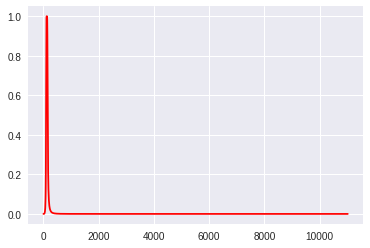

In [193]:
fs = float(sanje_mssp4.params['sample_rate'])
lowcut, highcut = 100, 150
# T = 5. # / (len(sanje_mssp4_data))
plt.figure(1)
plt.clf()
colors = 'rbycm'
for c, order in zip(colors, [3]):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sc.signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), '-'+c, label="order = %d" % order)
y = butter_bandpass_filter(sanje_mssp4_data, lowcut, highcut, fs, order=3)

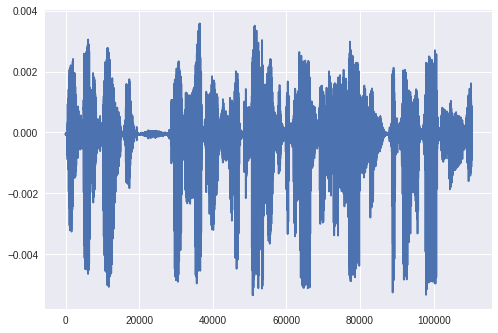

In [187]:
plt.plot(y)
# plt.plot(sanje_mssp4_data, alpha=0.3)

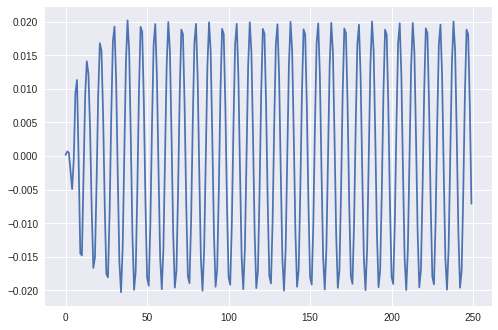

In [150]:
plt.plot(y)

In [0]:
fft_coefs = np.fft.fft(sanje_mssp4_data)

In [0]:
freq_vals = np.fft.fftfreq(len(fft_coefs), 1. / sanje_mssp4.params['sample_rate'])

<Container object of 3 artists>

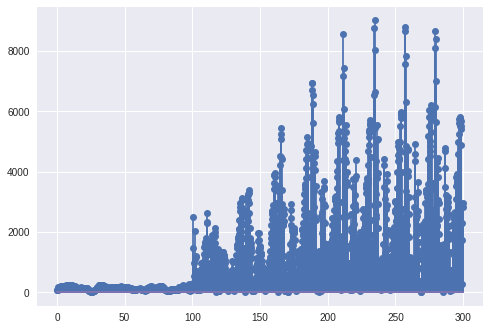

In [168]:
upto = 1500
plt.stem(freq_vals[:upto], np.abs(fft_coefs)[:upto])

## Psychoacoustic Features